<a href="https://colab.research.google.com/github/FilippoAiraldi/RL-demos/blob/main/gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gridworld

From "Reinforcement Learning: an introduction" by Sutton & Bard. \\
Inspired by: https://github.com/laxatives/rl/blob/master/gridworld_mdp.ipynb

In [1]:
import gym
from gym import spaces
from gym.utils import seeding

import numpy as np
import itertools

from tqdm.notebook import tqdm

from typing import Tuple, Callable, List, Union

## Definitions

In [13]:
Policy = Callable[[Tuple[int, int]], int]
Policy_All = Callable[[Tuple[int, int]], List[int]]

Actions = [
    (lambda s: (s[0] - 1, s[1]), (0, 1)),   # up
    (lambda s: (s[0], s[1] + 1), (1, 0)),   # right
    (lambda s: (s[0] + 1, s[1]), (0, -1)),  # down
    (lambda s: (s[0], s[1] - 1), (-1, 0))   # left
]

out_of_bounds = lambda s, d: s[0] < 0 or s[0] >= d or s[1] < 0 or s[1] >= d
state_shape = lambda env: tuple(space.n for space in env.observation_space)
state_action_shape = lambda env: (*state_shape(env), env.action_space.n)

class Gridworld(gym.Env):
    """
    5x5 2D grid environment.
    
    Available actions are:
        Up (0), Right(1), Down(2), Left(3)
    
    Rewards are:
        +10 from any action is tile (0, 1)
        +5 from any action is tile (0, 3)
        -1 for any action moving the state outside bounds (state left unchanged)
        0 for all other actions

    Observations are:
        a 2D tuple corresponding to the current tile
    """

    def __init__(self, init_state: Tuple[int, int] = None, 
                 done_if_outside_bounds: bool = False, done_if_A_or_B: bool = False):
        self.dim = 5
        self.done_if_out = done_if_outside_bounds
        self.done_if_AorB = done_if_A_or_B
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((spaces.Discrete(self.dim), spaces.Discrete(self.dim)))
        self.seed()
        self.reset(init_state)

    def seed(self, seed: int = None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action: int) -> Tuple[Tuple[int, int], int, bool]:
        assert self.action_space.contains(action)
        if self.state == (0, 1):  # special state A            
            s, r, done = (4, 1), 10, self.done_if_AorB
        elif self.state == (0, 3):  # specal state B
            s, r, done = (2, 3), 5, self.done_if_AorB
        else:
            s = Actions[action][0](self.state)
            out = out_of_bounds(s, self.dim)
            s, r, done = (self.state, -1, self.done_if_out) if out else (s, 0, False)
        self.state = s        
        return s, r, done
        
    def random_state(self) -> Tuple[int, int]:
        return tuple(self.np_random.randint(0, self.dim, size = 2))

    def reset(self, init_state: Tuple[int, int] = None) -> Tuple[int, int]:
        if init_state is None: init_state = self.random_state()
        self.state = init_state
        return self.state

    def render(self, mode = 'human'): 
        raise NotImplementedError('render not available')

## Visualization

In [3]:
import matplotlib.pyplot as plt

def display_values(values: np.ndarray, title: str = None, 
                   policy_plot: Policy_All = None):
    fig, ax = plt.subplots(figsize = (7, 5))
    if title: ax.set_title(title)    
    transformed_values = np.rot90(values.T)
    im = ax.imshow(transformed_values, cmap = 'hot')
    fig.colorbar(im, ax = ax)
    N, M = values.shape
    if policy_plot:
        for s in itertools.product(range(N), range(M)):
            actions = policy_plot(s)
            for action in actions:
                dx, dy = Actions[action][1]
                x, y = s[1], N - 1 - s[0]
                ax.arrow(x - 0.25 * dx, y - 0.25 * dy, 0.5 * dx, 0.5 * dy, head_width = 0.125)
    ax.set_xlim(-0.5, N - 0.5)
    ax.set_ylim(-0.5, M - 0.5)

def policy_from_state_values(env, s, state_values, gamma):
    actions = []
    max_action_value = float('-inf')
    for a in range(env.action_space.n):
        env.reset(s)
        s1, r1, _ = env.step(a)
        action_value = r1 + gamma * state_values[s1]
        if action_value > max_action_value:
            actions = [a]
            max_action_value = action_value
        elif action_value == max_action_value:
            actions.append(a)
    return actions

def policy_from_action_values(s, action_values):
    Qs = action_values[s]
    return np.argwhere(Qs == Qs.max()).flatten().tolist()

## Solvers

### Value Iteration

In [4]:
def value_iteration(env: Gridworld, policy_type: str, gamma: float = 0.9, K: int = 1000):
    states_dim = state_shape(env)
    state_values = np.zeros(states_dim)

    policy_type = policy_type.lower()
    if policy_type == 'random':
        for _, x, y in itertools.product(range(K), *(range(n) for n in states_dim)):
            state = x, y
            vs = 0
            for a in range(env.action_space.n):
                env.reset(state)
                new_state, reward, _ = env.step(a)
                vs += (reward + gamma * state_values[new_state]) / env.action_space.n
            state_values[state] = vs
        
    elif policy_type == 'optimal':
        for _, x, y in itertools.product(range(K), *(range(n) for n in states_dim)):
            state = x, y
            vs = state_values[state]
            optimal_val = float('-inf')
            for a in range(env.action_space.n):
                env.reset(state)
                new_state, reward, _ = env.step(a)
                new_val = reward + gamma * state_values[new_state]
                optimal_val = max(optimal_val, new_val)
            state_values[state] = optimal_val

    else:
        raise NotImplementedError(f'policy type must be either "random" or "optimal"')
    return state_values

array([[22. , 24.4, 22. , 19.4, 17.5],
       [19.8, 22. , 19.8, 17.8, 16. ],
       [17.8, 19.8, 17.8, 16. , 14.4],
       [16. , 17.8, 16. , 14.4, 13. ],
       [14.4, 16. , 14.4, 13. , 11.7]])

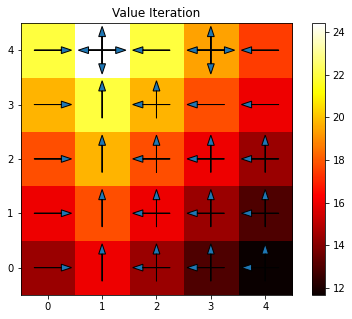

In [5]:
env = Gridworld()

# state_values = value_iteration(env, 'random', gamma = 0.9, K = 50)
# policy_plot = lambda _: range(env.action_space.n)

state_values = value_iteration(env, 'optimal', gamma = 0.9, K = 50)
policy_plot = lambda s: policy_from_state_values(env, s, state_values, 0.9)

display_values(state_values, 'Value Iteration', policy_plot)
state_values.round(1)

### Monte Carlo

#### Monte Carlo first/every-visit

In [6]:
def _generate_episode(env, policy, T):
    st = env.reset(env.random_state())
    S, A, R = [], [], []
    for _ in range(T):
        at = policy(st)
        st_1, rt_1, done = env.step(at)
        S.append(st)
        A.append(at)
        R.append(rt_1)
        if done: break
        st = st_1
    return S, A, R

def _update_returns(returns, key, x):
    avg, N = returns[key] if key in returns else (0.0, 0)
    returns[key] = (avg + (x - avg) / (N + 1), N + 1)
    return returns

def monte_carlo_prediction(env: Gridworld, gamma: float = 0.9, T: int = None, 
                           iters: int = 2000, first_visit: bool = False) -> np.ndarray:
    if T is None: T = int(1e6)
    returns = {} # hosts mean return and occurences count for each state
    policy = lambda _: env.action_space.sample()

    if first_visit:
        episode_returns = {} # host return for each state per episode
        for _ in range(iters):
            # simulate
            S, _, R = _generate_episode(env, policy, T)

            # replay backwards
            episode_returns.clear()
            G = 0
            for st, rt_1 in reversed(list(zip(S, R))):
                G = gamma * G + rt_1
                episode_returns[st] = G

            # update returns estimates with only the first visits
            for s, G in episode_returns.items():
                returns = _update_returns(returns, s, G)
    else:
        for _ in range(iters):
            # simulate
            S, _, R = _generate_episode(env, policy, T)
            
            # replay backwards
            G = 0
            for st, rt_1 in reversed(list(zip(S, R))):
                G = gamma * G + rt_1
                # update returns estimates for each visit
                returns = _update_returns(returns, st, G)

    # update state values V(s)
    state_values = np.zeros(state_shape(env))
    for s, (avg, _) in returns.items(): state_values[s] = avg
    return state_values

array([[ 3.1,  9. ,  4.4,  5.3,  1.3],
       [ 1.3,  2.8,  2.1,  1.8,  0.4],
       [-0. ,  0.7,  0.6,  0.3, -0.4],
       [-0.9, -0.3, -0.3, -0.5, -1. ],
       [-1.7, -1.1, -1. , -1.2, -1.7]])

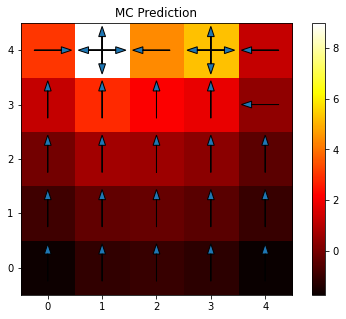

In [7]:
env = Gridworld()
state_values = monte_carlo_prediction(env, first_visit = False,  T = 32, iters = 5000)
policy_plot = lambda s: policy_from_state_values(env, s, state_values, 0.9)
display_values(state_values, 'MC Prediction', policy_plot)
state_values.round(1)

#### Monte Carlo Control

##### On-policy

In [45]:
def _generate_episode(env, policy, T, act0_random = False):
    st = env.reset(env.random_state())
    S, A, R = [], [], []
    for _ in range(T):
        at = env.action_space.sample() if act0_random else policy(st)
        st_1, rt_1, done = env.step(at)
        S.append(st)
        A.append(at)
        R.append(rt_1)
        if done: break
        st = st_1
        act0_random = False
    return S, A, R 

def onpolicy_monte_carlo_control(env: Gridworld, gamma: float = 0.9, eps: float = 0.01, T: int = None, 
                                  iters: int = 2000, first_visit: bool = False) -> np.ndarray:
    if T is None: T = int(1e6)
    returns = {} # hosts mean return and occurences count for each state-pair
    Q = env.np_random.rand(*state_action_shape(env))
    policy = lambda s: Q[s].argmax() if env.np_random.random() > eps else env.action_space.sample()

    if first_visit:
        episode_returns = {} # host return for each state-pair per episode
        for _ in tqdm(range(iters), total = iters):
            # simulate
            S, A, R = _generate_episode(env, policy, T, act0_random = True)

            # replay backwards
            episode_returns.clear()
            G = 0
            for st, at, rt_1 in reversed(list(zip(S, A, R))):
                G = gamma * G + rt_1
                episode_returns[(*st, at)] = G

            # update returns estimates with only the first visits
            for sa_pair, G in episode_returns.items():
                returns = _update_returns(returns, sa_pair, G)
                Q[sa_pair] = returns[sa_pair][0]
    else:
        for _ in tqdm(range(iters), total = iters):
            # simulate
            S, A, R = _generate_episode(env, policy, T)
            
            # replay backwards
            G = 0
            for st, at, rt_1 in reversed(list(zip(S, A, R))):
                G = gamma * G + rt_1
                # update returns estimates for each visit
                sa_pair = (*st, at)
                returns = _update_returns(returns, sa_pair, G)
                Q[sa_pair] = returns[sa_pair][0]
    return Q


################### SLOWER VERSION, MORE ADHERENT TO BOOK ###################

# def _update_policy(env, pi, s, Q, eps):
#     a_opt = Q[s].argmax()
#     pi[s] = eps / env.action_space.n
#     pi[(*s, a_opt)] = 1 - eps + eps / env.action_space.n
#     return pi

# def onpolicy_monte_carlo_control(env: Gridworld, gamma: float = 0.9, eps: float = 0.01, T: int = None, 
#                                   iters: int = 2000, first_visit: bool = False) -> np.ndarray:
#     if T is None: T = int(1e6)
#     returns = {} # hosts mean return and occurences count for each state-pair
#     Q = env.np_random.rand(*state_action_shape(env))
#     pi = np.ones_like(Q) / env.action_space.n
#     policy = lambda s: env.np_random.choice(range(env.action_space.n), p = pi[s])

#     if first_visit:
#         episode_returns = {} # host return for each state-pair per episode
#         for _ in tqdm(range(iters), total = iters):
#             # simulate
#             S, A, R = _generate_episode(env, policy, T)

#             # replay backwards
#             episode_returns.clear()
#             G = 0
#             for st, at, rt_1 in reversed(list(zip(S, A, R))):
#                 G = gamma * G + rt_1
#                 episode_returns[(*st, at)] = G

#             # update returns estimates with only the first visits
#             for sa_pair, G in episode_returns.items():
#                 returns = _update_returns(returns, sa_pair, G)
#                 Q[sa_pair] = returns[sa_pair][0]
#                 pi = _update_policy(env, pi, sa_pair[:-1], Q, eps)
#     else:
#         for _ in tqdm(range(iters), total = iters):
#             # simulate
#             S, A, R = _generate_episode(env, policy, T)
            
#             # replay backwards
#             G = 0
#             for st, at, rt_1 in reversed(list(zip(S, A, R))):
#                 G = gamma * G + rt_1
#                 # update returns estimates for each visit
#                 sa_pair = (*st, at)
#                 returns = _update_returns(returns, sa_pair, G)
#                 Q[sa_pair] = returns[sa_pair][0]
#                 pi = _update_policy(env, pi, sa_pair[:-1], Q, eps)
#     return Q

array([[17. , 17.9, 15.8, 14.5, 12.7],
       [14.8, 15.2, 14. , 12.4, 11.4],
       [13.1, 12.4, 12.4, 10.9, 10. ],
       [11.4, 10.6, 11. ,  9.6,  8.7],
       [ 9.5,  9.1,  9.5,  8.4,  7.5]])

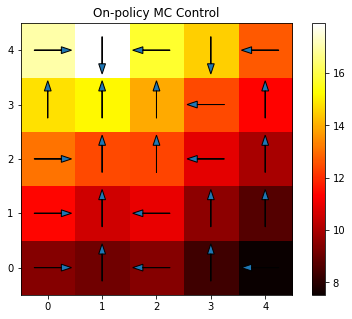

In [46]:
env = Gridworld()
action_values = onpolicy_monte_carlo_control(env, T = 16, iters = int(5e4), first_visit = True, eps = 0.01)
policy_plot = lambda s: policy_from_action_values(s, action_values)
display_values(action_values.max(-1), 'On-policy MC Control', policy_plot)
action_values.max(-1).round(1)

##### Off-policy

In [43]:
def offpolicy_monte_carlo_control(env: Gridworld, behavior_policy_type: str,
                                  gamma: float = 0.9, T: int = None, iters: int = 2000,
                                  eps: float = 1e-1) -> np.ndarray:

    if T is None: T = int(1e6)
    Q = env.np_random.rand(*state_action_shape(env))
    C = np.zeros_like(Q)
    target_policy = lambda s: Q[s].argmax()
    bp_type = behavior_policy_type.lower()
    assert bp_type in ['random', 'epsgreedy'], 'behavior policy can be "random" or "epsgreedy"'
    if bp_type == 'random':
        behavior_policy = lambda s: env.action_space.sample()
        behavior_policy_prob = lambda s, a: 1 / env.action_space.n
    else:
        behavior_policy = lambda s: target_policy(s) if env.np_random.random() > eps else env.action_space.sample()
        behavior_policy_prob = lambda s, a: eps if a != target_policy(s) else 1 - eps

    for _ in tqdm(range(iters), total = iters):
        # simulate
        S, A, R = _generate_episode(env, behavior_policy, T)
        
        # replay backwards
        G, W = 0, 1
        for st, at, rt_1 in reversed(list(zip(S, A, R))):
            G = gamma * G + rt_1
            sa_pair = (*st, at)
            C[sa_pair] += W
            Q[sa_pair] += W / C[sa_pair] * (G - Q[sa_pair])
            if at != target_policy(st): break
            W /= behavior_policy_prob(st, at)
    return Q

array([[15.6, 16.4, 14.3, 11.8, 12.8],
       [12.7, 13.6, 12.1,  9.7,  9.5],
       [10.8, 11.1, 10.6,  8.1,  8.4],
       [ 9.3,  9.3,  9.2,  8.3,  7.9],
       [ 7.9,  7.8,  8.3,  8. ,  7.6]])

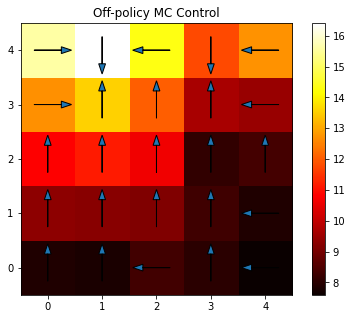

In [44]:
env = Gridworld()
action_values = offpolicy_monte_carlo_control(env, 'epsgreedy', T = 16, iters = int(5e4), eps = 0.25)
policy_plot = lambda s: policy_from_action_values(s, action_values)
display_values(action_values.max(-1), 'Off-policy MC Control', policy_plot)
action_values.max(-1).round(1)